# Model Experiments

In this notebook, we will experiment with different machine learning models and their configurations using the Australian Student Performance dataset.

In [ ]:
# Import necessary libraries
import sys
import os

sys.path.append(os.path.abspath('..'))

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from src.data.loader import load_data
from src.data.cleaning import clean_data, one_hot_encode
from src.data.balancing import balance_dataset
from src.data.split import split_data
from src.data.pca import principal_component_analysis
from src.data.label_processing import LabelProcessor
from src.models.model_factory import create_model
from src.training.trainer import Trainer
from src.evaluation.evaluate import evaluate_model
from src.training.hyperparameter_tuning import HyperparameterTuner
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import numpy as np
import pandas as pd
from sklearn.preprocessing import label_binarize
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier



In [ ]:
# load and clean the data
df = load_data('../data/raw/Australian_Student_PerformanceData (ASPD24).csv')
cleaned_data = clean_data(df)

# Strip whitespace on column names
cleaned_data.columns = cleaned_data.columns.str.strip()

In [25]:
# split data
X = cleaned_data.drop(columns=["Performance"])
y = cleaned_data["Performance"]

X_train, X_val, X_test, y_train, y_val, y_test = split_data(
    X, y, test_size=0.2, val_size=0.1, random_state=42
)


In [26]:

# encode data
le = LabelProcessor()
y_train = le.encode_labels(y_train)
y_val   = le.encode_labels(y_val)
y_test  = le.encode_labels(y_test)

In [27]:
# defined feature types
drop_columns = ["Student ID", "University ID"]

numeric_features = [
    "Age", "Year of Study", "GPA", "High School GPA", "Entrance Exam Score",
    "Attendance Rate", "Participation in Extracurricular Activities",
    "Part-time Job", "Hours of Study per Week", "Family Income",
    "Distance from Home to University", "Internet Access at Home",
    "Library Usage", "Access to Academic Resources", "Scholarship",
    "Financial Aid", "Tutor Support", "Counseling Services",
    "Hours of Sleep per Night", "Exercise Frequency", "Peer Support",
    "Use of Online Learning Platforms", "Project/Assignment Scores",
    "Midterm Exam Scores", "Final Exam Scores", "Attendance at Office Hours",
    "Group Work Participation", "Research Involvement",
    "Internship Experience", "Peer Reviews", "Academic Advising",
    "Core Course Average", "Extracurricular Participation",
    "Peer Evaluations"
]

ordinal_features = [
    "Health Condition", "Mental Health Status", "Diet Quality",
    "Social Integration", "Language Proficiency",
    "Study Environment", "Class Participation"
]

ordinal_categories = [
    ["Poor", "Fair", "Good", "Excellent"],  # Health Condition
    ["Poor", "Fair", "Good", "Excellent"],  # Mental Health Status
    ["Poor", "Fair", "Good", "Excellent"],  # Diet Quality
    ["Poor", "Fair", "Good", "Excellent"],  # Social Integration
    ["Poor", "Fair", "Good", "Excellent"],  # Language Proficiency
    ["Poor", "Fair", "Good", "Excellent"],  # Study Environment
    ["Poor", "Fair", "Good", "Excellent"]   # Class Participation
]

nominal_features = [
    "University Name", "Gender", "Major",
    "Parental Education Level", "Accommodation Type",
    "Transportation Mode", "Learning Style"
]

In [28]:
# clomntransformer - preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("drop_ids", "drop", drop_columns),
        ("num", StandardScaler(), numeric_features),
        ("ord", OrdinalEncoder(categories=ordinal_categories), ordinal_features),
        ("nom", OneHotEncoder(handle_unknown="ignore", drop="first"), nominal_features),
    ],
    remainder="drop"
)

In [ ]:
# models and parameters for pipeline - only lightGBM at first

models = {
    "LightGBM": LGBMClassifier(random_state=42, verbose=-1),
    "RandomForest": RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    )
}

'''
param_grids = { # this gave AUC 0.5 which is expected
    "LightGBM": {
        "clf__n_estimators": [200, 400],
        "clf__learning_rate": [0.025, 0.075],
        "clf__num_leaves": [31, 63],
        "clf__max_depth": [-1, 10],
        "clf__min_child_samples": [15],
        "clf__subsample": [0.7, 1.0],
        "clf__colsample_bytree": [0.7, 1.0],
    }
}
'''
param_grids = { # best parameters from a set we tested
    "LightGBM": {
        "clf__n_estimators": [150],
        "clf__learning_rate": [0.1],
        "clf__num_leaves": [63],
        "clf__max_depth": [-1]
    },

    "RandomForest": {
        "clf__n_estimators": [200],
        "clf__max_depth": [10],
        "clf__min_samples_split": [10],
        "clf__min_samples_leaf": [1]
    }
}

# pipline for many models
pipelines = {
    name: Pipeline([
        ("prep", preprocessor),
        ("clf", model)
    ])
    for name, model in models.items()
}

In [ ]:
# gridsearch setup
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_models = {}
results = []

for name, pipe in pipelines.items():
    print(f"\n Training model: {name}")
    
    '''
    grid = GridSearchCV( # this was slow, data is quite big
        estimator=pipe,
        param_grid=param_grids[name],
        cv=cv,
        scoring="roc_auc_ovr",
        n_jobs=-1,
        verbose=1
    )
    '''
    grid = HalvingGridSearchCV( # using this instead of regular gridsearch because regular takes kind of really long time lik 2h supposedly, this takes like 20mins to find the best parameters
    estimator=pipe,
    param_grid=param_grids[name],
    factor=3,                    # how aggressively to halve
    scoring="roc_auc_ovr",
    cv=cv,
    min_resources="exhaust",
    max_resources="auto",
    n_jobs=-1,
    verbose=1
    )
    
    grid.fit(X_train, y_train)
    
    print("Best params:", grid.best_params_)
    print("Best CV AUC:", grid.best_score_)
    
    best_models[name] = grid.best_estimator_

    # VALIDATION
    y_val_pred = grid.predict(X_val)
    y_val_proba = grid.predict_proba(X_val)
    
    y_val_bin = label_binarize(y_val, classes=np.unique(y_train))
    
    val_acc = accuracy_score(y_val, y_val_pred)
    val_auc = roc_auc_score(y_val_bin, y_val_proba, multi_class="ovr")
    
    results.append({
        "Model": name,
        "Validation Accuracy": val_acc,
        "Validation AUC": val_auc
    })

print("\n Validation results: ")
for r in results:
    print(r)




 Training model: LightGBM
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 7136
max_resources_: 64232
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 16
n_resources: 7136
Fitting 5 folds for each of 16 candidates, totalling 80 fits
----------
iter: 1
n_candidates: 6
n_resources: 21408
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 2
n_candidates: 2
n_resources: 64224
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best params: {'clf__learning_rate': 0.1, 'clf__max_depth': -1, 'clf__n_estimators': 150, 'clf__num_leaves': 63}
Best CV AUC: 0.5033324246139484

 Training model: RandomForest
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 7136
max_resources_: 64232
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 16
n_resources: 7136
Fitting 5 folds for each of 16 candidates, totalling 80 fits
----------
iter: 1
n_candidates: 6
n_resou

In [ ]:
# test validation
print("\nFinal test results: ")

for name, model in best_models.items():
    print(f"\nModel: {name}")

    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)

    y_test_bin = label_binarize(y_test, classes=np.unique(y_train))

    test_acc = accuracy_score(y_test, y_test_pred)
    test_auc = roc_auc_score(y_test_bin, y_test_proba, multi_class="ovr")

    print("Test Accuracy:", test_acc)
    print("Test AUC:", test_auc)
    print(classification_report(y_test, y_test_pred))



=== FINAL TEST RESULTS ===

Model: LightGBM
Test Accuracy: 0.28436254980079684
Test AUC: 0.5076828703402049
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       212
           1       0.23      0.06      0.10       425
           2       0.25      0.23      0.24       502
           3       0.21      0.01      0.03       283
           4       0.31      0.73      0.43       586

    accuracy                           0.28      2008
   macro avg       0.20      0.21      0.16      2008
weighted avg       0.23      0.28      0.21      2008


Model: RandomForest
Test Accuracy: 0.29233067729083667
Test AUC: 0.5060168200749837
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       212
           1       0.00      0.00      0.00       425
           2       0.50      0.00      0.00       502
           3       0.00      0.00      0.00       283
           4       0.29      1.00      0.45   

In [34]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

def plot_macro_roc(best_models, X_test, y_test, label_encoder):
    classes = np.unique(y_test)
    y_test_bin = label_binarize(y_test, classes=classes)
    mean_fpr = np.linspace(0, 1, 100)

    plt.figure(figsize=(10, 8))

    for name, model in best_models.items():
        y_proba = model.predict_proba(X_test)

        # per-class ROC
        tprs = []
        aucs = []

        for i in range(len(classes)):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0

            tprs.append(interp_tpr)
            aucs.append(auc(fpr, tpr))

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0

        macro_auc = np.mean(aucs)
        std_auc = np.std(aucs)

        plt.plot(
            mean_fpr, mean_tpr,
            lw=2,
            label=f"{name} (AUC = {macro_auc:.3f} ± {std_auc:.3f})"
        )

    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Macro-Average ROC Curves (Test Set)")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


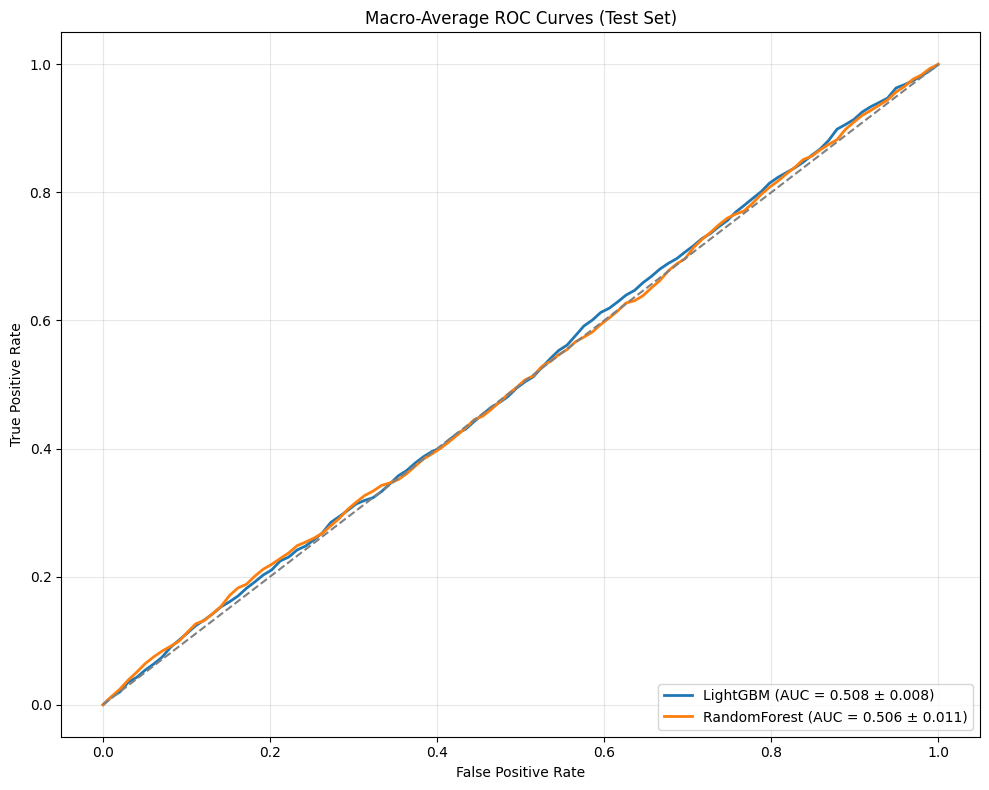

In [36]:
plot_macro_roc(best_models, X_test, y_test, le)

In [37]:
def plot_per_class_roc(best_models, X_test, y_test, label_encoder):
    classes = np.unique(y_test)
    class_labels = label_encoder.decode_labels(classes)

    mean_fpr = np.linspace(0, 1, 100)

    for name, model in best_models.items():
        plt.figure(figsize=(10, 8))
        y_test_bin = label_binarize(y_test, classes=classes)
        y_proba = model.predict_proba(X_test)

        for i, cls in enumerate(classes):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0

            auc_score = auc(fpr, tpr)

            plt.plot(
                mean_fpr,
                interp_tpr,
                lw=2,
                label=f"Class {class_labels[cls]} (AUC = {auc_score:.3f})"
            )

        plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"Per-Class ROC Curves for {name} (Test Set)")
        plt.legend(loc="lower right")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

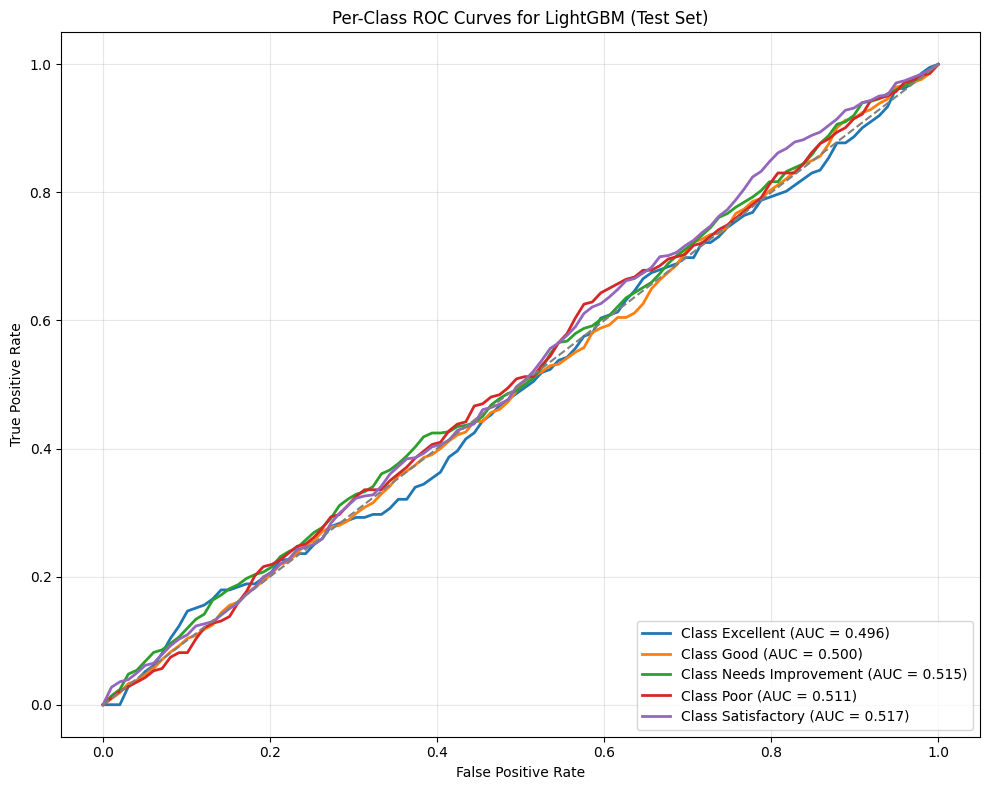

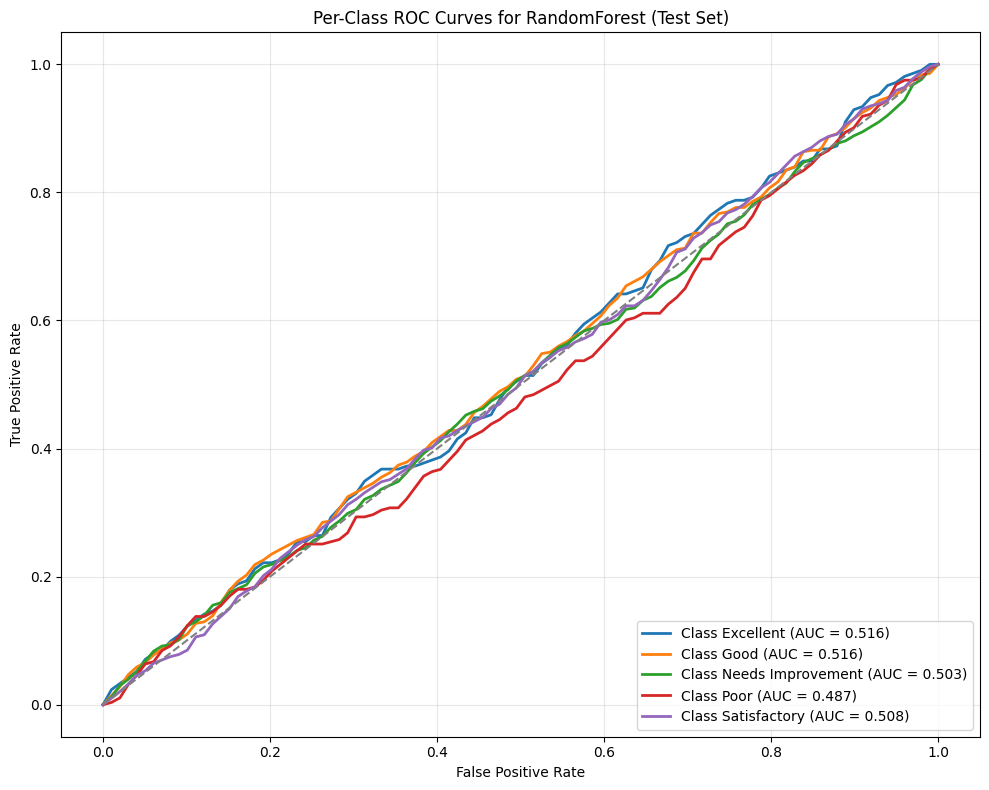

In [38]:
plot_per_class_roc(best_models, X_test, y_test, le)